# **Dependancies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/btc_data')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import *
from keras.callbacks import *
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from commons import mean_absolute_percentage_error
from keras.layers import *
from sklearn.pipeline import Pipeline

# **Loading Data**

In [6]:
import pandas as pd

# Đường dẫn đến file btc_data.csv
file_path = '/content/drive/My Drive/Colab Notebooks/btc_data/BTC_Data_2014-2022.csv'

# Đọc file CSV
data = pd.read_csv(file_path)





# Hiển thị 5 dòng đầu tiên
print(data.head(50))


          Date  priceUSD      size  sentbyaddress  transactions  \
0   2014/04/09   447.110  243742.0         122401         64992   
1   2014/04/10   407.703  254334.0         124298         67872   
2   2014/04/11   403.328  223656.0         117926         65563   
3   2014/04/12   425.310  169964.0          87828         47579   
4   2014/04/13   415.876  162260.0          94828         50981   
5   2014/04/14   445.898  216048.0         127969         70026   
6   2014/04/15   487.666  241539.0         123107         72627   
7   2014/04/16   517.354  270984.0         114312         68435   
8   2014/04/17   505.461  223631.0         102596         65021   
9   2014/04/18   485.296  205478.0         100633         56836   
10  2014/04/19   490.961  193237.0          93159         53356   
11  2014/04/20   501.271  169511.0          88713         48865   
12  2014/04/21   498.970  190616.0          93895         57939   
13  2014/04/22   491.704  288040.0         125522         7788

Epoch 0, Learning rate: 0.001
Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0510 - mae: 0.1285 - val_loss: 0.0226 - val_mae: 0.1206 - learning_rate: 0.0010
Epoch 1, Learning rate: 0.001
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - mae: 0.0274 - val_loss: 0.0091 - val_mae: 0.0778 - learning_rate: 0.0010
Epoch 2, Learning rate: 0.001
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0013 - mae: 0.0193 - val_loss: 0.0045 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 3, Learning rate: 0.001
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011 - mae: 0.0167 - val_loss: 0.0012 - val_mae: 0.0267 - learning_rate: 0.0010
Epoch 4, Learning rate: 0.001
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.8715e-04 - mae: 0.0147 - val_loss: 0.0021 - val_mae: 0.0356 - learning_rate: 0.0010
Epoch 5, Learning rate: 0.001
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.8813e-04 - mae: 0.0121 - val_loss: 6.

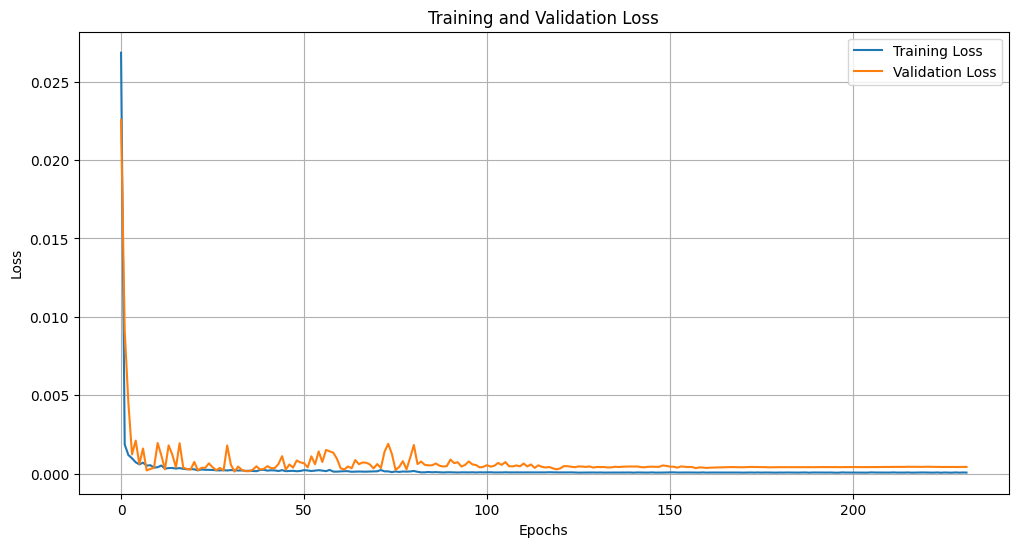

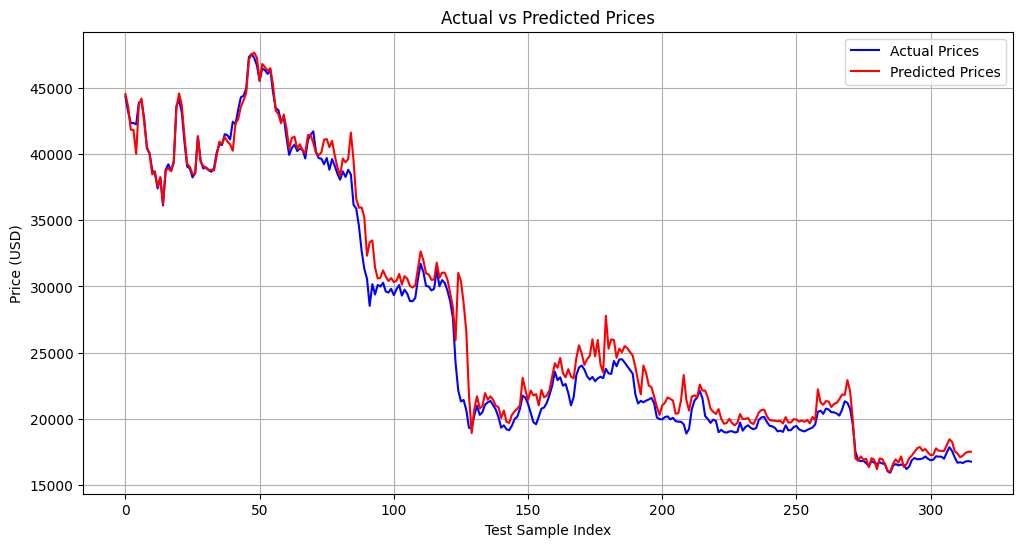

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Đọc và chuẩn bị dữ liệu


# Tính các chỉ số phụ trợ (Volatility, Moving Average)
#data['Volatility_30'] = data['priceUSD'].rolling(window=30).std()
#data['MA_30'] = data['priceUSD'].rolling(window=30).mean()

# Chỉ sử dụng dữ liệu sau 90 ngày (bỏ đi các hàng đầu tiên có NaN)
data = data.iloc[29:]

# Chọn cột đặc trưng và mục tiêu
X = data.drop(columns=['priceUSD', 'Date'])  # Loại bỏ 'priceUSD' và 'Date' khỏi đặc trưng đầu vào
y = data['priceUSD']  # Cột mục tiêu là 'priceUSD'

# Chia dữ liệu theo thời gian, 90% đầu tiên cho tập huấn luyện, 10% cuối cho tập kiểm tra
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Chuẩn hóa dữ liệu
X_scaler = RobustScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Reshape dữ liệu cho mô hình LSTM-CNN
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Xác định thư mục lưu mô hình và kết quả CSV
save_dir = '/content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7'  # Adjust path as needed
os.makedirs(save_dir, exist_ok=True)

# Xây dựng mô hình LSTM-CNN
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    # LSTM Layer
    LSTM(256, return_sequences=True, activation='tanh'),
    Dropout(0.3),

    # CNN Layer
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=1),  # Chỉnh sửa pool_size thành 1 để tránh thu nhỏ quá mức dữ liệu

    # LSTM Layer 2
    LSTM(128, return_sequences=True, activation='tanh'),
    Dropout(0.2),

    # CNN Layer 2
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=1),  # Cũng giảm pool_size cho lớp thứ hai

    # LSTM Layer 3
    LSTM(64, return_sequences=False, activation='tanh'),

    # Fully connected layers
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Biên dịch mô hình
adam = Adam(learning_rate=1e-4, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])

# Callbacks
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print(f"Epoch {epoch}, Learning rate: {lr}")
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

mcp_save = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'best_model_LSTM_CNN_V10.keras'),
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=200, verbose=1, mode='min')

callbacks = [lr_scheduler, mcp_save, early_stopping]

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train_scaled,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test_scaled),
    callbacks=callbacks
)

# Lưu mô hình cuối cùng
final_model_path = os.path.join(save_dir, 'model_LSTM_CNN_V10.keras')
model.save(final_model_path)
print(f"Model saved at: {final_model_path}")

# Dự đoán
y_pred = model.predict(X_test)

# Chuyển ngược scale dữ liệu dự đoán và thực tế
y_pred_original = y_scaler.inverse_transform(y_pred)
y_test_original = y_scaler.inverse_transform(y_test_scaled)

# Đánh giá mô hình
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print("Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")

# Hiển thị kết quả dự đoán và thực tế
results = pd.DataFrame({
    'Actual': y_test_original.flatten(),
    'Predicted': y_pred_original.flatten()
})
print(results.head(10))

# Lưu kết quả vào file CSV
results_path = os.path.join(save_dir, 'result_predictions_LSTM_CNN.csv')
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")

# Đồ thị lịch sử huấn luyện
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Đồ thị dự đoán và thực tế
#plt.figure(figsize=(12, 6))
#plt.plot(y_test_original.flatten(), label='Actual Prices', color='blue')
#plt.plot(y_pred_original.flatten(), label='Predicted Prices', color='red')
#plt.title('Actual vs Predicted Prices')
#plt.xlabel('Test Sample Index')
#plt.ylabel('Price (USD)')
#plt.legend()
#plt.grid()
#plt.show()


Model loaded successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


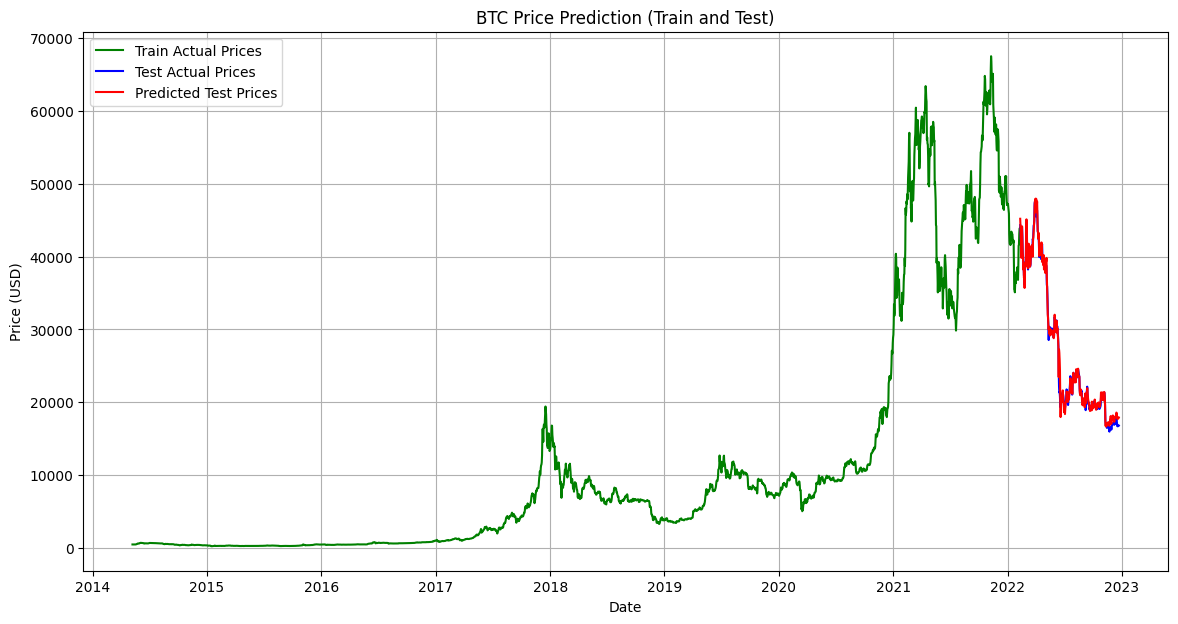

Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/result_predictions_test.csv


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

# Đường dẫn tới mô hình đã lưu
model_path = '/content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/best_model_LSTM_CNN_V10.keras'

# Tải mô hình tốt nhất đã lưu
model = load_model(model_path)
print("Model loaded successfully.")

# Dự đoán trên tập test
y_pred_test = model.predict(X_test)

# Chuyển ngược scale dữ liệu
y_pred_test_original = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

y_train_original = y_scaler.inverse_transform(y_train_scaled.reshape(-1, 1))

# Đảm bảo cột 'Date' là kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Đồ thị toàn bộ dữ liệu
plt.figure(figsize=(14, 7))

# Plot dữ liệu train
plt.plot(data.iloc[:split_index]['Date'], y_train_original.flatten(), label='Train Actual Prices', color='green')

# Plot dữ liệu test
plt.plot(data.iloc[split_index:]['Date'], y_test_original.flatten(), label='Test Actual Prices', color='blue')

# Plot dự đoán tập test
plt.plot(data.iloc[split_index:]['Date'], y_pred_test_original.flatten(), label='Predicted Test Prices', color='red')

# Thông tin đồ thị
plt.title('BTC Price Prediction (Train and Test)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Date': data.iloc[split_index:]['Date'],
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': y_pred_test_original.flatten()
})

# Lưu vào file CSV
results_path = '/content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/result_predictions_test.csv'
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")


Model loaded successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


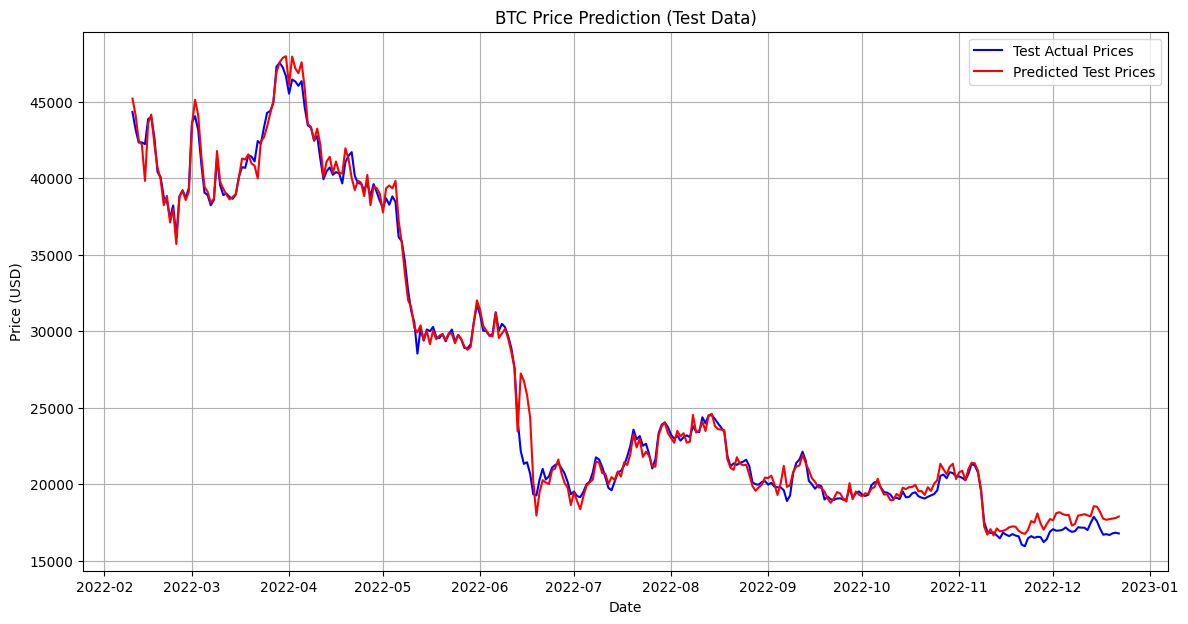

Predictions saved to: /content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/result_predictions_test.csv


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model

# Đường dẫn tới mô hình đã lưu
model_path = '/content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/best_model_LSTM_CNN_V10.keras'

# Tải mô hình tốt nhất đã lưu
model = load_model(model_path)
print("Model loaded successfully.")

# Dự đoán trên tập test
y_pred_test = model.predict(X_test)

# Chuyển ngược scale dữ liệu
y_pred_test_original = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_original = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# Đảm bảo cột 'Date' là kiểu datetime
data['Date'] = pd.to_datetime(data['Date'])

# Đồ thị dữ liệu tập test
plt.figure(figsize=(14, 7))

# Plot dữ liệu test (thực tế)
plt.plot(data.iloc[split_index:]['Date'], y_test_original.flatten(), label='Test Actual Prices', color='blue')

# Plot dữ liệu test (dự đoán)
plt.plot(data.iloc[split_index:]['Date'], y_pred_test_original.flatten(), label='Predicted Test Prices', color='red')

# Thông tin đồ thị
plt.title('BTC Price Prediction (Test Data)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Date': data.iloc[split_index:]['Date'],
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': y_pred_test_original.flatten()
})

# Lưu vào file CSV
results_path = '/content/drive/My Drive/Colab Notebooks/btc_data/btc_data_model_CNN_V7/result_predictions_test.csv'
results.to_csv(results_path, index=False)
print(f"Predictions saved to: {results_path}")


# **Testing Model**